## Evaluate trained priorCVAE model

In [1]:
import random

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax.linen as nn
import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.datasets import GPDataset
from priorCVAE.priors import SquaredExponential, Matern32, Matern52
from priorCVAE.models import MLPDecoder, MLPDecoderTwoHeads
from priorCVAE.utility import load_model_params
from experiments.exp_utils import plot_decoder_samples

In [14]:
model_path = r"../outputs/trained_models/e7kvvkr0/model/"

hidden_dim = 60
latent_dim = 40
out_dim = 80
batch_size = 40
# activation = nn.leaky_relu

x0 = 0
x1 = 1

x = jnp.linspace(0, 1, out_dim)
decoder_params = load_model_params(model_path)["decoder"]

## TwoHeadDecoder Plot

In [15]:
decoder = MLPDecoderTwoHeads(hidden_dim, out_dim)

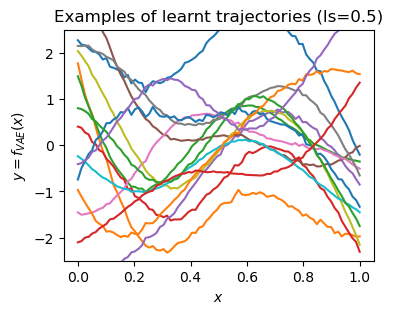

In [19]:
plot_decoder_samples(decoder, decoder_params, .5, latent_dim, x, n=15, plot_mean=True)

## Single head

In [9]:
def get_decoder_samples(ls, decoder, decoder_params):
    z_rng = jax.random.PRNGKey(random.randint(0, 9999))
    z = jax.random.normal(z_rng, (batch_size, latent_dim))

    c = ls * jnp.ones((z.shape[0], 1))
    z_c = jnp.concatenate([z, c], axis=-1)
    out = decoder.apply({'params': decoder_params}, z_c)
    
    return out

In [10]:
decoder = MLPDecoder(hidden_dim, out_dim)

In [11]:
test_ls_list = [.05, .1, .2, .4, .5, .6, .8, 1.]

In [12]:
for ls in test_ls_list:
    decoder_samples = get_decoder_samples(ls=ls, decoder=decoder, decoder_params=decoder_params)
    kernel = SquaredExponential(lengthscale=ls, variance=1.)
    
    true_kernel_gp_dataset = GPDataset(kernel, out_dim, x0, x1, sample_lengthscale=False)
    _, true_samples, _ = true_kernel_gp_dataset.simulatedata(batch_size)
    
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    for i in range(batch_size):
        axs[0].plot(x, decoder_samples[i], color="tab:blue", alpha=0.2)
        axs[1].plot(x, true_samples[i], color="tab:red", alpha=0.2)


    axs[0].set_xlim([x0, x1]) 
    axs[1].set_xlim([x0, x1]) 

    axs[0].set_ylim([-3, 3]) 
    axs[1].set_ylim([-3, 3]) 

    axs[0].set_title(f"Decoder samples (ls={ls})")
    axs[1].set_title(f"Kernel samples (ls={ls})")
    
#     plt.savefig("comparison.png")
    
    plt.show()

ScopeParamNotFoundError: Could not find parameter named "kernel" in scope "/dec_out". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamNotFoundError)